# Анализ гипотез и A/B теста
В нашем распоряжение данные крупного интернет-магазина. Перед нами стоит две задачи: во-первых, необходимо изучить поставленные гипотезы и выбрать наиболее потенциальные, провести приоритизацию, во-вторых, провести анализ результатов A/B тестов и выяснить есть ли лидирование одной из групп или необходимо продолжить тестирование.

Файл с гипотезами имеет следущую структуру:

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Результаты A/B тестов хранятся в двух файлах, имеющих следующую структуру:

Заказы:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Посещения:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import numpy as np

## Знакомство с данными

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
try:
    orders = pd.read_csv('orders.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
try:
    visitors = pd.read_csv('visitors.csv')
except:
    visitors = pd.read_csv('/datasets/visitors.csv')

In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Вывод**

На первый взгляд данные хорошие - без пропусков, в достаточном для анализа количестве. Есть небольшие рассхождения с "хорошим" стилем в названиях столбцов. Замечены несоответсвия с типом данных с столбцах с датами.

## Предобработка данных

In [11]:
# проверим наличие дубликатов в таблицах

print('В таблице с гипотезами', hypothesis.duplicated().sum(), 'дубликатов')
print('В таблице с заказами', orders.duplicated().sum(), 'дубликатов')
print('В таблице с посещениями', visitors.duplicated().sum(), 'дубликатов')

В таблице с гипотезами 0 дубликатов
В таблице с заказами 0 дубликатов
В таблице с посещениями 0 дубликатов


In [12]:
# поменяем тип данных в столбцах с датами

orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [13]:
hypothesis.columns = [name.lower() for name in hypothesis.columns]

**Вывод**

В данных не обнаружены явные дубликаты. Типы данных были приведены в соотвествие. Названия столбцов были скорректированы для удобства. Можно приступать к анализу.

## Приоритизация гипотез

In [14]:
# Оценим приоритетность гипотез через фреймворк ICE

hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
print(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

                                          hypothesis        ice
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


Наиболее перспективные гипотезы по ICE - 8, 0, 7.

In [15]:
# Оценим приоритетность гипотез через фреймворк RICE

hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
print(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

                                          hypothesis   rice
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


Наиболее перспективные гипотезы по RICE - 7, 2, 0, 6.

По результатам тестирования гипотезы можно условно разделить на 2 части: те что совсем плохи и те что неплохи. И внутри своей группы гипотезы немного смещаются в заивимости от метода проверки.

В результате проверок мы выявили, что наиболее перспективными гипотезами являются 7 и 0.

Колллебания гипотез внутри групп происходят из-за того что в первая проверка, в отличие от второй, не учитывает число пользователей, которых затронет предположение.

In [16]:
print(hypothesis.loc[0, 'hypothesis'])
print(hypothesis.loc[7, 'hypothesis'])

Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок


## Анализ A/B-теста

### Проверка стабильности кумулятивных метрик

Чтобы исключить проблему подсматривания, проанализируем графики метрик. 
Изучим графики кумулятивных, или накапливаемых данных. По центральной предельной теореме значение кумулятивных метрик часто сходится и устанавливается около некоторого среднего. Тогда по графику кумулятивных метрик можно определить, стоит останавливать тест или нет. 

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (
    datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
           .agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 'visitorId': 'nunique', 'revenue': 'sum',}),
           axis=1,)
    .sort_values(by=['date', 'group'])
)

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = (
    datesGroups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
           .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
           axis=1,)
    .sort_values(by=['date', 'group']))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors',]

# датафрейм с кумулятивными данными по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'orders', 'buyers', 'revenue', 'visitors']]
# датафрейм с кумулятивными данными по дням в группе В
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'orders', 'buyers', 'revenue', 'visitors']]

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

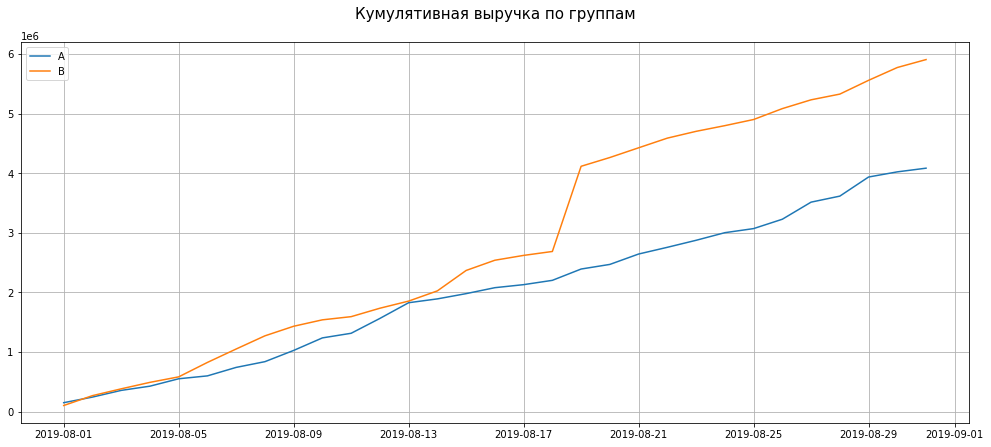

In [18]:
# Построим графики кумулятивной выручки по дням и группам A/B-тестирования
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('Кумулятивная выручка по группам' + '\n', fontsize = 15)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак. Показатели группы В стабильно лучше, однако на графике заметен большой выброс между 18 и 19 августа. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Необходимо исследовать данный выброс.

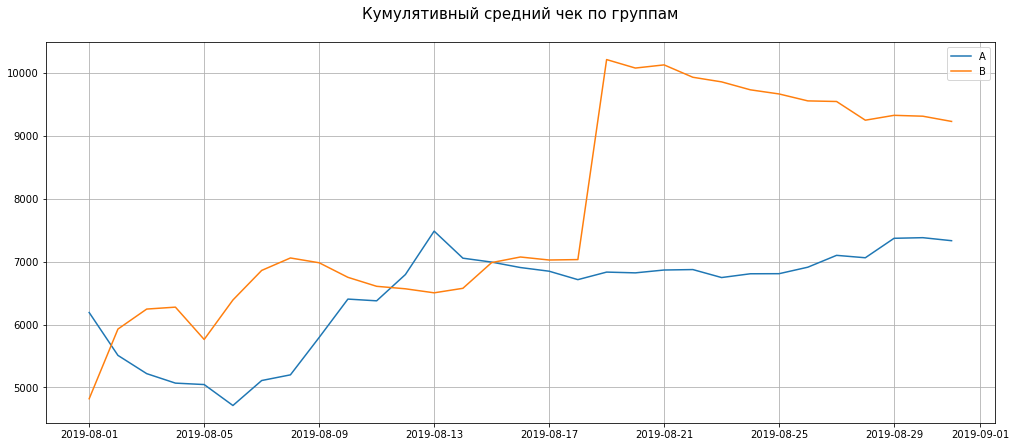

In [19]:
# Построим графики среднего чека по дням и группам A/B-тестирования
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('Кумулятивный средний чек по группам' + '\n', fontsize = 15)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')
plt.legend();

Средний чек группы В на графике имеет сильный скачок - выброс, упомянутый ранее. После него показатели какое-то время снижались, но, кажется, держатся стабильно в последние 4-5 дней эксперимента. Средний чек группы А стабилизировался.

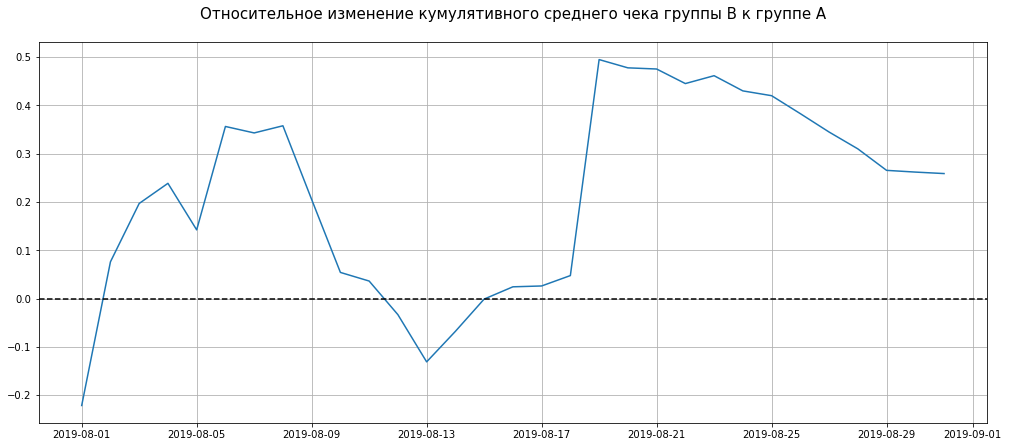

In [20]:
# cтроим отношение средних чеков
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('Относительное изменение кумулятивного среднего чека группы B к группе A' + '\n', fontsize = 15)
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

В нескольких точках график различия между сегментами резко скачет. В основном заметно преимущество группы В, однако причиной может быть выброс за 18 августа.

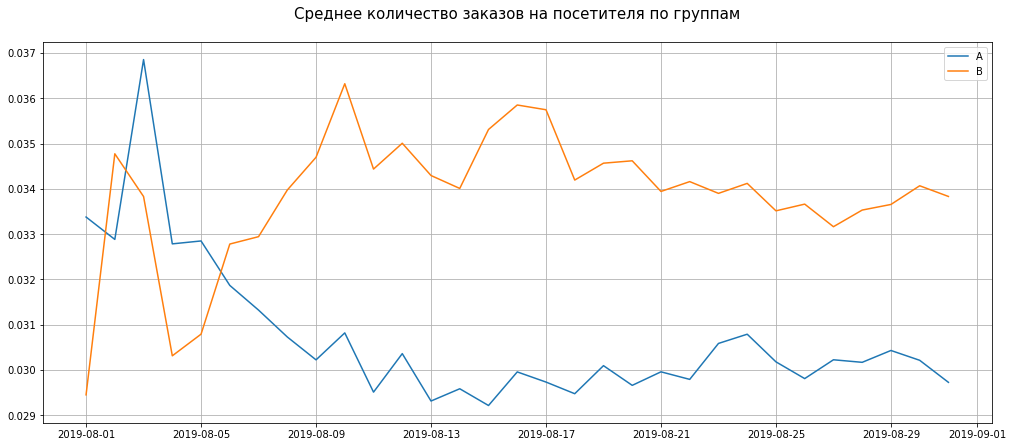

In [21]:
# Построим графики среднего количества заказов по дням и группам A/B-тестирования
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('Среднее количество заказов на посетителя по группам' + '\n', fontsize = 15)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['orders'] / cumulativeRevenueA['visitors'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['orders'] / cumulativeRevenueB['visitors'], label='B')
plt.legend();

Начиная с 6 августа показатели группы В стабильно лучше. За 18 августа скачков нет, значит выброс графике по выручке не связан с аномалями с числом заказов.

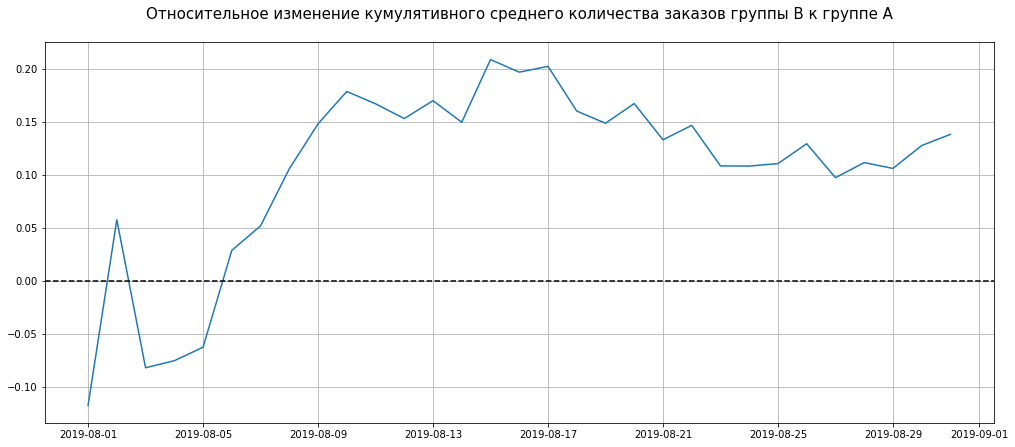

In [22]:
# cтроим отношение среднего числа заказов
fig, ax = plt.subplots(figsize=(17, 7))
ax.grid()
ax.set_title('Относительное изменение кумулятивного среднего количества заказов группы B к группе A' + '\n', fontsize = 15)
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['ordersB']/mergedCumulativeRevenue['visitorsB'])
         /(mergedCumulativeRevenue['ordersA']/mergedCumulativeRevenue['visitorsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

В начале эксперимента заметны большие скачки, однако уже во второй трети график начинает стабилизироваться, показывая стабильно более хорошие для группы В результаты, относительно группы А.

### Анализ выбросов и всплесков

In [23]:
ordersByUsers = (orders
                 .groupby('visitorId', as_index=False)
                 .agg({'transactionId': 'nunique'})
                 )

ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head()

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


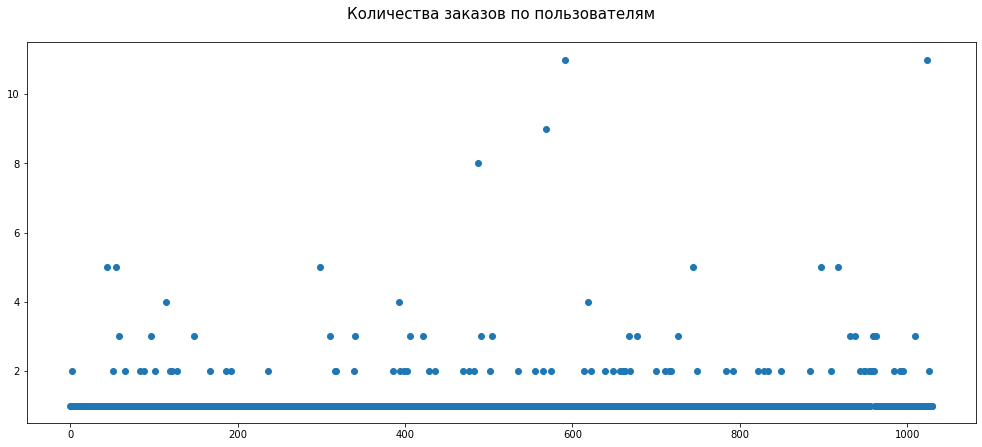

In [24]:
x_values = pd.Series(range(0, len(ordersByUsers)))
fig, ax = plt.subplots(figsize=(17, 7))
ax.set_title('Количества заказов по пользователям' + '\n', fontsize = 15)
plt.scatter(x_values, ordersByUsers['orders']);

Большинство пользователей совершило не больше одного заказа.

По графику сложно сказать, начиная с какого количества заказов пользователя можно отнесьти к аномальным. Для этого посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [25]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершили больше 2 заказов и лишь 1% совершил более 4 заказов.
Таким образом, аномальными будут считаться пользователи, совершившие более 2 заказов.

In [26]:
orders.sort_values(by='revenue', ascending=False).head()

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B


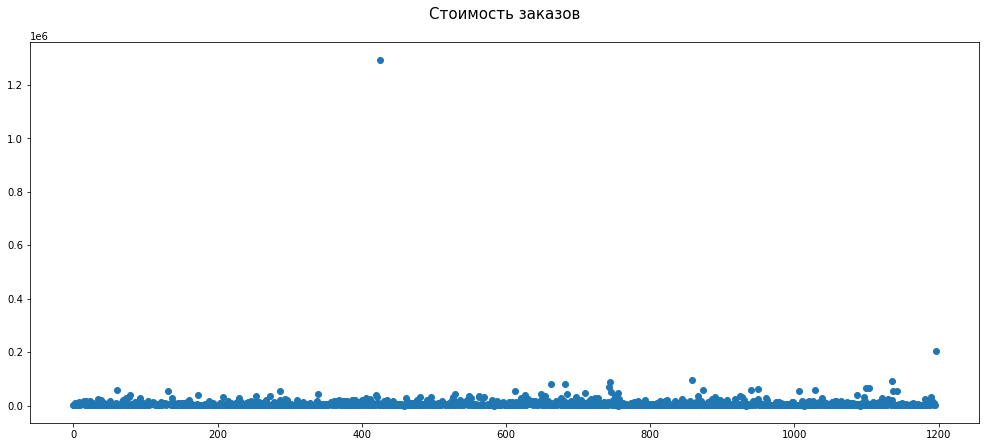

In [27]:
x_values = pd.Series(range(0, len(orders)))
fig, ax = plt.subplots(figsize=(17, 7))
ax.set_title('Стоимость заказов' + '\n', fontsize = 15)
plt.scatter(x_values, orders['revenue']);

Очень сильно выбивается заказ стоимость больше миллиона, из-за чего сложно сказать какова стоимость заказа у большинства пользователей. Можно уверено сказать, что она не превышает 100 тысяч.

In [28]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% пользователей делает заказ стомостью более 28 тысяч и лишь 1% делали заказ стоимость более 58233.
Таким образом, аномальными будут считаться заказы стоимостью более 30 000.

### Подсчет статистической значимости различий в метриках

In [29]:
# считаем количество пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# считаем количество пользователей до выбранной даты в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# считаем количество пользователей в выбранную дату в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# считаем количество пользователей до выбранной даты в группе В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# считаем количество заказов и выручку в выбранную дату в группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# считаем суммарное число заказов и суммарную выручку до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# считаем количество заказов и выручку в выбранную дату в группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# считаем суммарное число заказов и суммарную вырочку до выбранной даты включительно в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединяем все расчеты во одну таблицу
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [30]:
# Найдем пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# Каждому пользователю поставим в соответсвие его число заказов
sampleA = pd.concat(
    [ordersByUsersA['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders',)
     ,], axis=0,
)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders',),
    ], axis=0,
)

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [31]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


**Вывод:** По «сырым» данным различия в среднем числе заказов групп A и B есть. 
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8% — второе число в выводе.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [32]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


**Вывод:** По «сырым» данным различий в среднем чеке групп A и B нет. 
Первое число — p-value = 0.729 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем. Однако относительный выигрыш группы B равен 25.9% — второе число в выводе.

Узнаем, как действия аномальных пользователей (число заказов >2, сумма покупки >30000) повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным.

Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [33]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
     ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ], axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd
    .concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId']
                                   .isin(abnormalUsers))]['orders'],
     pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
               name='orders',),
    ], axis=0,
)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId']
                                   .isin(abnormalUsers))]['orders'],
     pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
               name='orders',),
    ], axis=0,
)

In [34]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.013
0.172


**Вывод:** По «чистым» данным различия в среднем числе заказов групп A и B также есть. Pазница между сегментами только увеличилась.

In [35]:
print(
    '{0:.3f}'
    .format(stats
            .mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
                          orders[np.logical_and(orders['group'] == 'B',
                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1])
)

print(
    "{0:.3f}"
    .format(orders[np.logical_and(orders['group'] == 'B',
                                  np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean() /
            orders[np.logical_and(orders['group'] == 'A',
                                  np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean() - 1)
)

0.720
-0.023


**Вывод:** По «чистым» данным различия в среднем чеке групп A и B также нет. P-value почти не изменился, но разница между сегментами сильно поменялась с 25.9% до -2.3%.

## Выводы

Во время исследования перед нами было поставленно 2 задачи. Кратко прорезюмируем полученные выводы в ходе их выполнения.

- При поиске наиболее потенциальных гипотез было использовано 2 способа: RICE и ICE, чьи результаты немного разнились из-за того, что второй не учитывает объем пользователей на которых окажет влияние изменения. По результатам обоих тестов самыми потенциальными гипотезами стали:
  -  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
  -  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
  

- При исследовании результатов Α/Β тестов были найдены аномальные значения, которые особо не повлияли на результаты работы. Было выявлено, что общая выручка и число заказов лучше и группы В. Графики кумулятивных метрик группы В еще немного колеблятся, однако их уровень значительно выше метрик группы А, чьи результаты уже стабилизировались. Я считаю, что тест можно заканчивать, присуждая победу группе В.